Датасет **tmdb_data** содержит информацию о фильмах, собранную с платформы TMDB

- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `production_countries` - список стран, учавствовавших в производстве фильма

Датасет **cpi_data** содержит информацию о значении cpi на каждый месяц с 1913 года

- `cpi_date` - дата (ГГГГ-ММ-01)
- `cpi` - значение cpi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns', None)

- Загружаем датасеты, оставляя необходимые столбцы 
- Преобразовываем типы данных (`year` в датасете cpi_data и `release_date` в tmdb_data)
- Переименовываем столбец `year` в датасете cpi_data на `cpi_date`

In [3]:
columns_tmdb = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries"   
]

In [4]:
df_tmdb = pd.read_csv(
    '../data/raw/tmdb_data.csv',
    usecols=columns_tmdb,
    parse_dates=['release_date']
    )
df_cpi = pd.read_csv(
    '../data/raw/cpi_data.csv',
    parse_dates=['year']
    ).rename(columns={'year': 'cpi_date'})

In [5]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cpi_date  1349 non-null   datetime64[ns]
 1   cpi       1349 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.2 KB


In [6]:
print(f'''Датасет df_cpi состоит из:
- {df_cpi.shape[0]} строк
- {df_cpi.shape[1]} столбцов''')

Датасет df_cpi состоит из:
- 1349 строк
- 2 столбцов


In [7]:
df_cpi.head(3)

,cpi_date,cpi
0,1913-01-01,9.80
1,1913-02-01,9.80
2,1913-03-01,9.80


- Объявляем переменную **latest_cpi**, которая будет хранить информацию о последнем зафиксированном значении cpi

In [8]:
latest_cpi = df_cpi.loc[df_cpi['cpi_date'].idxmax(), 'cpi']
print(f'Значение актуального CPI = {latest_cpi}')

Значение актуального CPI = 321.465


In [9]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243889 entries, 0 to 1243888
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1243889 non-null  int64         
 1   title                 1243876 non-null  object        
 2   vote_average          1243889 non-null  float64       
 3   release_date          1009427 non-null  datetime64[ns]
 4   revenue               1243889 non-null  int64         
 5   budget                1243889 non-null  int64         
 6   original_language     1243889 non-null  object        
 7   original_title        1243876 non-null  object        
 8   genres                723902 non-null   object        
 9   production_countries  669919 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 94.9+ MB


In [10]:
print(f'''Датасет df_tmdb состоит из:
- {df_tmdb.shape[0]} строк
- {df_tmdb.shape[1]} столбцов''')

Датасет df_tmdb состоит из:
- 1243889 строк
- 10 столбцов


- Сохраняем в переменную **old_rows** данные о количестве строк в датасете с фильмами до предобработки, чтобы позже оценить количество удаленной информации

In [11]:
old_rows = df_tmdb.shape[0]
old_rows

1243889

### Смена типов данных

In [12]:
df_tmdb.dtypes

id                               int64
title                           object
vote_average                   float64
release_date            datetime64[ns]
revenue                          int64
budget                           int64
original_language               object
original_title                  object
genres                          object
production_countries            object
dtype: object

Типы данных корректны

- Преобразуем содержимое строковых данных к нижнему регистру, чтобы избежать возможных дубликатов

In [13]:
str_column = df_tmdb.select_dtypes(include='object').columns
for col in str_column:
    df_tmdb[col] = df_tmdb[col].str.lower().str.strip()
df_tmdb[str_column].head(3)

,title,original_language,original_title,genres,production_countries
0,inception,en,inception,"action, science fiction, adventure","united kingdom, united states of america"
1,interstellar,en,interstellar,"adventure, drama, science fiction","united kingdom, united states of america"
2,the dark knight,en,the dark knight,"drama, action, crime, thriller","united kingdom, united states of america"


### Объединяем датафреймы

- Объединяем df_tmdb и df_cpi по дате начала месяца. Для этого добавим новый столбец в df_tmdb, который приведет release_date к началу месяца

In [14]:
df_tmdb['release_month'] = (df_tmdb['release_date']
                            .dt.to_period('M')
                            .dt.to_timestamp()
                            )
df_tmdb['release_month'].head(2)

0   2010-07-01
1   2014-11-01
Name: release_month, dtype: datetime64[ns]

In [15]:
df_merged = df_tmdb.merge(df_cpi,
                          left_on='release_month',
                          right_on='cpi_date',
                          how='inner')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997723 entries, 0 to 997722
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    997723 non-null  int64         
 1   title                 997719 non-null  object        
 2   vote_average          997723 non-null  float64       
 3   release_date          997723 non-null  datetime64[ns]
 4   revenue               997723 non-null  int64         
 5   budget                997723 non-null  int64         
 6   original_language     997723 non-null  object        
 7   original_title        997719 non-null  object        
 8   genres                667560 non-null  object        
 9   production_countries  632100 non-null  object        
 10  release_month         997723 non-null  datetime64[ns]
 11  cpi_date              997723 non-null  datetime64[ns]
 12  cpi                   997723 non-null  float64       
dtyp

### Проверка на дубликаты

In [16]:
print(f'Найдено {df_merged.duplicated().sum()} полных дубликатов строк')

Найдено 169 полных дубликатов строк


- удаляем их

In [17]:
df_merged = df_merged.drop_duplicates().reset_index(drop=True)
df_merged.duplicated().sum()

np.int64(0)

- Проверим, есть ли дубликаты по столбцам с информацией об оригинальном названии фильма и датой релиза

In [18]:
print(f'''Найдено {df_merged[['original_title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 1965 дубликатов


- Фильмы с одинаковым оригинальным названием и одинаковой датой релиза могут указывать на дубликаты - удаляем их

In [19]:
df_merged = df_merged.drop_duplicates(subset=['original_title', 'release_date'])
df_merged = df_merged.reset_index(drop=True)

Одинаковые названия фильмов действительно могут встречаться - главное, чтобы даты релизов не совпадали

- Теперь проверим дубликаты, связанные с англоязычным названием и датой релиза

In [20]:
print(f'''Найдено {df_merged[['title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 343 дубликатов


In [21]:
df_merged[df_merged.duplicated(subset=['title', 'release_date'], keep=False)][['title', 'release_date']].value_counts()

title                       release_date
fatal love                  1993-01-01      3
chosen 2                    2020-01-13      3
resurrection of love        1973-01-01      2
run!                        2013-10-23      2
rolling                     2016-09-16      2
                                           ..
god's gift                  1998-01-01      2
girls                       2014-07-30      2
ghost story of kam pin mui  1991-06-22      2
ghost                       2023-10-19      2
zhanxiou village            2007-05-20      2
Name: count, Length: 341, dtype: int64

Проверим фильм  `chosen 2`, чтобы понять, стоит ли нам считать совпадение по дате релиза и англоязычному названию - дубликатами

In [22]:
df_merged[df_merged['title'] == 'chosen 2']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
457325,1160180,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅰ救赎,NaN,NaN,2020-01-01,2020-01-01,257.97
457328,1160183,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅱ同盟,NaN,NaN,2020-01-01,2020-01-01,257.97
457329,1160184,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅲ重生,NaN,NaN,2020-01-01,2020-01-01,257.97


In [23]:
df_merged[df_merged['title'] == 'zhanxiou village']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
513140,1405386,zhanxiou village,0.00,2007-05-20,0,0,zh,朱辛庄,NaN,china,2007-05-01,2007-05-01,207.95
544936,1469333,zhanxiou village,0.00,2007-05-20,0,0,en,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95
566545,1264836,zhanxiou village,0.00,2007-05-15,0,0,fr,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95


- Оригинальные названия разные, судя по всему, это могут быть разные части одного проекта, релизнутые в один день. 

Совпадения по дате релиза и англоязычному названию НЕ указывают на дубликаты

In [24]:
new_rows = df_merged.shape[0]
print(f'''Было удалено {old_rows - new_rows} строк.
Мы лишились {round((old_rows - new_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 248300 строк.
Мы лишились 19.96% данных


### Анализ пропусков

In [25]:
df_merged.isnull().sum().sort_values(ascending=False)

production_countries    364365
genres                  329348
title                        4
original_title               4
id                           0
vote_average                 0
release_date                 0
revenue                      0
budget                       0
original_language            0
release_month                0
cpi_date                     0
cpi                          0
dtype: int64

In [26]:
(df_merged.isnull().mean() * 100).sort_values(ascending=False).round(2)

production_countries   36.60
genres                 33.08
title                   0.00
original_title          0.00
id                      0.00
vote_average            0.00
release_date            0.00
revenue                 0.00
budget                  0.00
original_language       0.00
release_month           0.00
cpi_date                0.00
cpi                     0.00
dtype: float64

У нас отсутствует свыше 40% информации по странам производства и жанрам. Также есть пропуски в 17% информации о дате релиза, 18% пропусков по информации о cpi.


- Данные CPI у нас есть с 1913 года, поэтому исключим фильмы, для которых не определено CPI

In [27]:
df_merged = df_merged[df_merged['cpi'].notna()].reset_index(drop=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995589 entries, 0 to 995588
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    995589 non-null  int64         
 1   title                 995585 non-null  object        
 2   vote_average          995589 non-null  float64       
 3   release_date          995589 non-null  datetime64[ns]
 4   revenue               995589 non-null  int64         
 5   budget                995589 non-null  int64         
 6   original_language     995589 non-null  object        
 7   original_title        995585 non-null  object        
 8   genres                666241 non-null  object        
 9   production_countries  631224 non-null  object        
 10  release_month         995589 non-null  datetime64[ns]
 11  cpi_date              995589 non-null  datetime64[ns]
 12  cpi                   995589 non-null  float64       
dtyp

Кажется, что в столбце бюджета и дохода пропусков нет, однако там пропущенные значения могут обозначаться как 0

In [28]:
df_merged['budget'].value_counts()

budget
0          945549
100          1574
1000         1409
10000        1314
500          1217
            ...  
574000          1
777900          1
2504000         1
32125           1
140985          1
Name: count, Length: 5337, dtype: int64

### Анализ REVENUE

In [29]:
def millions(x, pos):
    '''Функция используется с FuncFormat 
    для форматирования значения x в миллионах 
    с округлением до одного знака после запятой'''
    return f'{x * 1e-6:.1f}'

In [30]:
df_merged['revenue'].value_counts()

revenue
0           976148
100            354
1              319
10             164
1000           163
             ...  
53672080         1
74918            1
32704700         1
26576000         1
9960000          1
Name: count, Length: 14118, dtype: int64

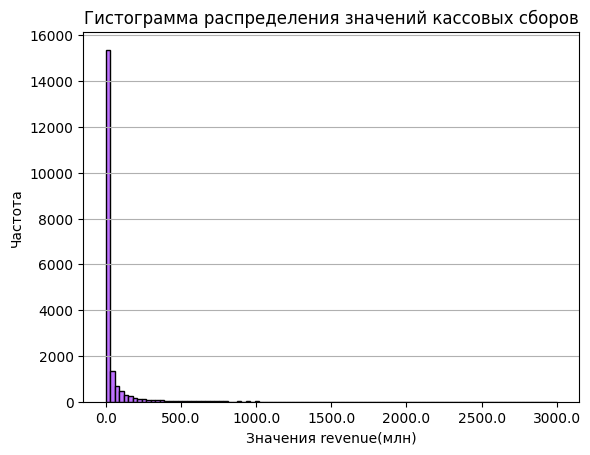

In [31]:
plt.hist(df_merged[df_merged['revenue'] > 0]['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Значения revenue(млн)')
plt.ylabel('Частота')

plt.show()

Большая часть данных хранит в себе значение "0" в столбце кассовых сборов (доходов). 

In [32]:
df_merged['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,995589.00,764187.97,18601909.74,-12.00,0.00,0.00,0.00,3000000000.00


Высокое значение стандартного отклонения указывает на большой разброс данных - есть выбросы. Учитывая, что 75-й квантиль равен 0, можно сделать вывод - большинство данных не имеют информации о кассовых сборах  

In [33]:
print(f'''Ненулевых значений обнаружено - {df_merged[df_merged['revenue'] > 0]['revenue'].count()}''')

Ненулевых значений обнаружено - 19440


- Объявим переменную, которая будет хранить булевую маску со значениями, где кассовые сборы были больше 0

In [34]:
filter_not_zero = df_merged['revenue'] > 0
filter_not_zero.head(3)

0    True
1    True
2    True
Name: revenue, dtype: bool

- Объявим переменные, которые будут хранить значения 30-го и 99-го квантиля

In [35]:
quantile_min = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.3)
print(f'''Значение 30-го процентиля = {quantile_min.round(2)}''')

Значение 30-го процентиля = 164306.1


In [36]:
quantile_max = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.99)
print(f'''Значение 99-го процентиля = {quantile_max.round(2)}''')

Значение 99-го процентиля = 626177688.56


Отфильтруем наш датасет по значениям от 30-го квантиля до 99-го, чтобы избавиться от аномальных значений 

In [37]:
df_filtered = df_merged[(df_merged['revenue'] > quantile_min) & (df_merged['revenue'] < quantile_max)]
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82


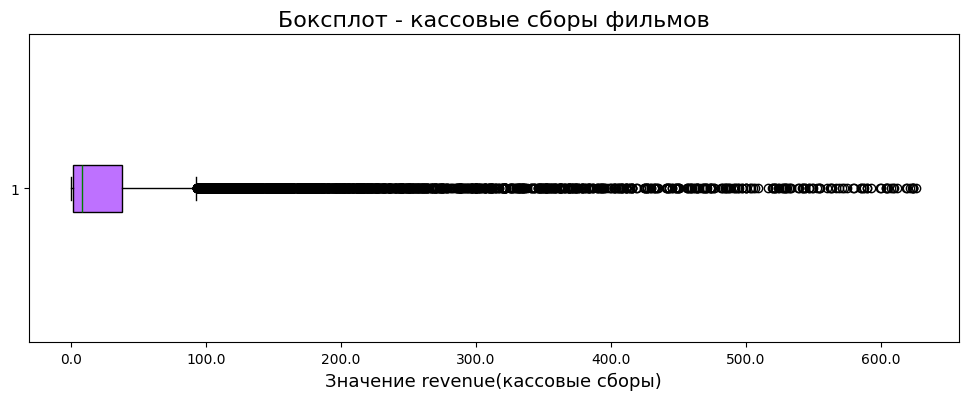

In [38]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['revenue'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.title('Боксплот - кассовые сборы фильмов', fontsize=16)
plt.xlabel('Значение revenue(кассовые сборы)', fontsize=13)

plt.show()

На боксплоте видно, что все аномальные значения находятся справа - их довольно много. 
Это бестселлеры, которые действительно получили огромные кассовые сборы

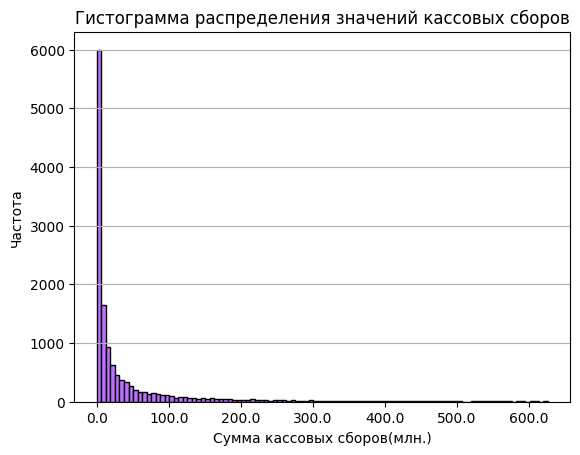

In [39]:
plt.hist(df_filtered['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Сумма кассовых сборов(млн.)')
plt.ylabel('Частота')

plt.show()

In [40]:
df_filtered['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,13413.00,42304439.24,84606338.06,164313.00,1778391.00,8645411.00,38332994.00,626137675.00


In [41]:
filtered_rows = df_filtered.shape[0]
print(f'''Было удалено {old_rows - filtered_rows} строк.
Мы лишились {round((old_rows - filtered_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 1230476 строк.
Мы лишились 98.92% данных


### Анализ BUDGET

In [42]:
print(f'''{df_filtered[df_filtered['budget'] == 0].shape[0]} количество фильмов не содержат информации о бюджете ''')

4386 количество фильмов не содержат информации о бюджете 


In [43]:
print(f'''{df_filtered[df_filtered['budget'] > 0].shape[0]} количество фильмов содержат информацию о бюджете''')

9027 количество фильмов содержат информацию о бюджете


In [44]:
df_filtered['budget'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
budget,13413.00,15751662.34,30090363.97,0.00,0.00,3000000.00,18900000.00,645654654.00


Мы видим большое стандратное отклонение, которое указывает на выбросы. У 25% фильмов отсутсвует информация о бюджете

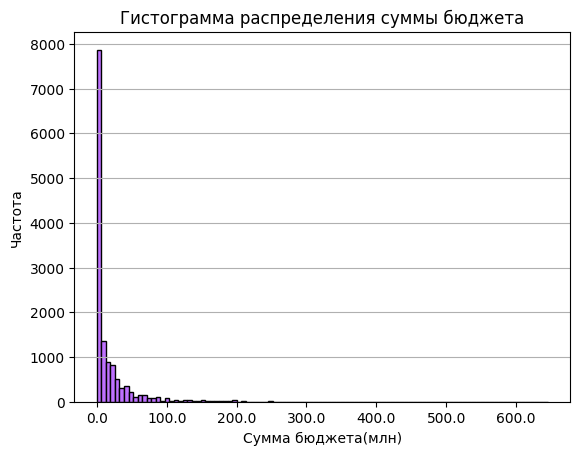

In [45]:
plt.hist(df_filtered['budget'],
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения суммы бюджета')
plt.xlabel('Сумма бюджета(млн)')
plt.ylabel('Частота')


plt.show()

- Распределение сильно смещено вправо: встречаются редкие, но очень крупные бюджеты
- Около 25% фильмов имеют нулевой бюджет, это значит, что данные либо отсутствуют - это типичная ситуация для фильмов, финансируемых: государственными субсидиями, международными фондами, кинокомиссиями.

По этой причине нулевые значения мы оставляем 

### Анализ PRODUCTION_COUNTRIES

In [46]:
df_filtered['production_countries'].value_counts()

production_countries
united states of america                                                         5863
india                                                                             703
united kingdom, united states of america                                          419
japan                                                                             412
united kingdom                                                                    330
                                                                                 ... 
france, united kingdom, italy                                                       1
australia, china, france, hong kong, united kingdom, united states of america       1
denmark, france, germany, japan, united kingdom, united states of america           1
france, germany, india, united states of america                                    1
russia, united states of america, japan                                             1
Name: count, Length: 1133, dtype:

In [47]:
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82


### Анализ VOTE_AVERTAGE

In [48]:
df_filtered['vote_average'].value_counts()

vote_average
0.00    388
6.00    224
7.00    150
6.50    139
6.20    129
       ... 
7.80      1
5.52      1
8.05      1
5.09      1
8.44      1
Name: count, Length: 3269, dtype: int64

У нас действительно могут встречаться фильмы без оценок пользователей, так что тут значение 0 не критично

In [49]:
df_filtered['vote_average'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
vote_average,13413.00,6.18,1.48,0.00,5.74,6.39,7.00,10.00


Стандартное отклонение не критичное, а значит вариативность умеренная

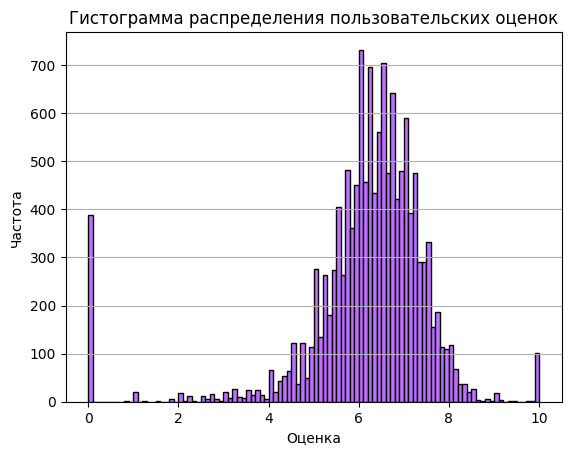

In [50]:
plt.hist(df_filtered['vote_average'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.grid(axis='y')

plt.title('Гистограмма распределения пользовательских оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.show()

- Распределение с левосторонней ассиметрией
- Вытянутый левый хвост обусловлен наличием свыше 900 нулевых оценок

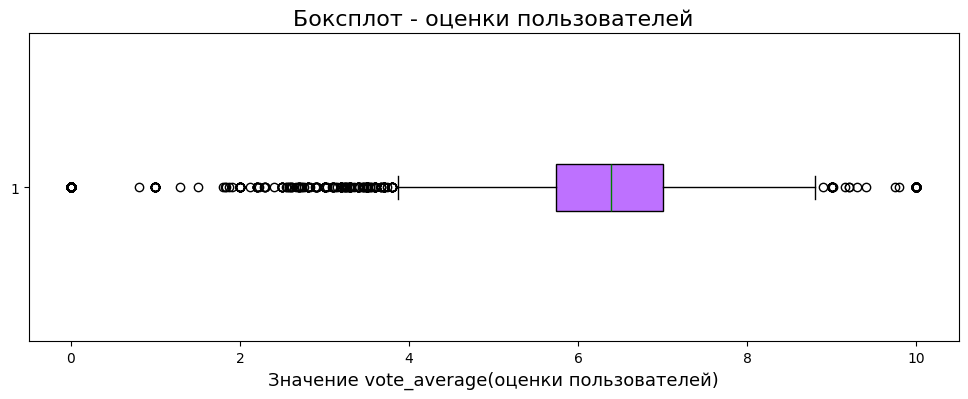

In [51]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['vote_average'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.title('Боксплот - оценки пользователей', fontsize=16)
plt.xlabel('Значение vote_average(оценки пользователей)', fontsize=13)

plt.show()

- Основная часть оценок приходится на значения ~5.6-6.97. Слева у нас наблюдается много выбросов, справа выбросы тоже есть, но их меньше. 
- Низкая оценка, как и ее отсутствие, может быть связана с малой популярностью фильма, возможно даже полным отсутствием популярности. 
- Высокая оценка может быть связана с большой положительной популярностью фильма, а также присутствует и такой вариант, что фильм не особо известен, у него не так много оценок - но все высокие. Тогда наша средняя оценка сильно завышается

### Уникальные значения

- Уникальные значения в жанрах

In [52]:
df_filtered['genres'].value_counts()

genres
drama                                                            996
comedy                                                           917
drama, romance                                                   487
comedy, drama                                                    425
comedy, romance                                                  410
                                                                ... 
mystery, drama, thriller, comedy                                   1
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
action, documentary                                                1
Name: count, Length: 2331, dtype: int64

- У нас встречаются строки с перечислением нескольких жанров. Для нашего исследования мы оставляем их в исходном виде. При построении дашборда предполагается использовать проверку по жанрам через оператор LIKE (SQL)

In [53]:
print(f'''У {df_filtered['genres'].isnull().sum()} фильмов отсутствует информация о жанрах''')

У 93 фильмов отсутствует информация о жанрах


- Нулевые значения можно заменить на "undefined"

In [54]:
df_filtered['genres'] = df_filtered['genres'].fillna('undefined')

/tmp/ipykernel_8960/3432640581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['genres'] = df_filtered['genres'].fillna('undefined')


In [55]:
df_filtered['genres'].value_counts()

genres
drama                                            996
comedy                                           917
drama, romance                                   487
comedy, drama                                    425
comedy, romance                                  410
                                                ... 
war, action, history, thriller                     1
mystery, drama, thriller, comedy                   1
family, comedy, adventure, animation, fantasy      1
adventure, action, fantasy, war, history           1
action, documentary                                1
Name: count, Length: 2332, dtype: int64

Изучим уникальные данные по столбцу с original_language

In [56]:
df_tmdb['original_language'].value_counts()

original_language
en    676047
fr     72737
es     63734
de     57953
ja     54513
       ...  
ts         1
ii         1
rn         1
an         1
kg         1
Name: count, Length: 176, dtype: int64

- Пропуски отсутствуют - данные выглядят полными

### Учет инфляции 

Добавим два столбца:
- `current_budget` - бюджет с учетом инфляции
- `current_revenue` - кассовые сборы с учетом инфляции

In [57]:
df_filtered['current_budget'] = (
    df_filtered['budget'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['budget', 'current_budget']].head(3)

/tmp/ipykernel_8960/4200148618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_budget'] = (


,budget,current_budget
7,63000000,120406034.48
9,8500000,18289508.03
12,140000000,209498517.38


In [58]:
df_filtered['current_revenue'] = (
    df_filtered['revenue'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['revenue', 'current_revenue']].head(3)

/tmp/ipykernel_8960/3040352102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_revenue'] = (


,revenue,current_revenue
7,100853753,192752388.28
9,213900000,460250090.36
12,585174222,875665228.00


### Итог 

In [59]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13413 entries, 7 to 995548
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13413 non-null  int64         
 1   title                 13413 non-null  object        
 2   vote_average          13413 non-null  float64       
 3   release_date          13413 non-null  datetime64[ns]
 4   revenue               13413 non-null  int64         
 5   budget                13413 non-null  int64         
 6   original_language     13413 non-null  object        
 7   original_title        13413 non-null  object        
 8   genres                13413 non-null  object        
 9   production_countries  13061 non-null  object        
 10  release_month         13413 non-null  datetime64[ns]
 11  cpi_date              13413 non-null  datetime64[ns]
 12  cpi                   13413 non-null  float64       
 13  current_budget      

In [60]:
columns_to_keep = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries",
    "cpi", 
    "current_budget",
    "current_revenue"  
]

In [61]:
df_filtered = df_filtered[columns_to_keep].copy()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13413 entries, 0 to 13412
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13413 non-null  int64         
 1   title                 13413 non-null  object        
 2   original_title        13413 non-null  object        
 3   original_language     13413 non-null  object        
 4   release_date          13413 non-null  datetime64[ns]
 5   genres                13413 non-null  object        
 6   budget                13413 non-null  int64         
 7   revenue               13413 non-null  int64         
 8   vote_average          13413 non-null  float64       
 9   production_countries  13061 non-null  object        
 10  cpi                   13413 non-null  float64       
 11  current_budget        13413 non-null  float64       
 12  current_revenue       13413 non-null  float64       
dtypes: datetime64[ns

In [62]:
df_filtered['release_date'].min()


Timestamp('1913-11-24 00:00:00')

In [63]:
print(f'''Наш отфильтрованный и предобработанный датасет состоит из:
- {df_filtered.shape[0]} строк
- {df_filtered.shape[1]} столбцов''')

Наш отфильтрованный и предобработанный датасет состоит из:
- 13413 строк
- 13 столбцов




- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `main_country` - главная страна, учавствовавшая в производстве фильма
- `cpi` - cpi на дату выхода фильма
- `latest_cpi` - актуальный cpi
- `current_budget` - сумма бюджета с учетом инфляции
- `current_revenue` - сумма кассовых сборов с учетом инфляции

 ## Графики (примеры + могут дополняться)

**scatter plot - corrent_revenue vs vote_average**


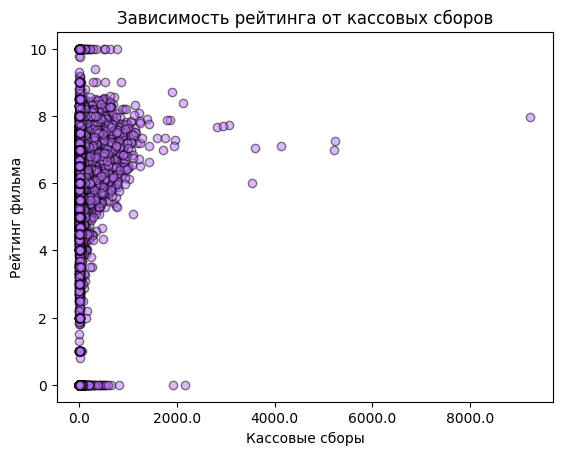

In [64]:
plt.scatter(
    df_filtered['current_revenue'],
    df_filtered['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Уберем выбросы

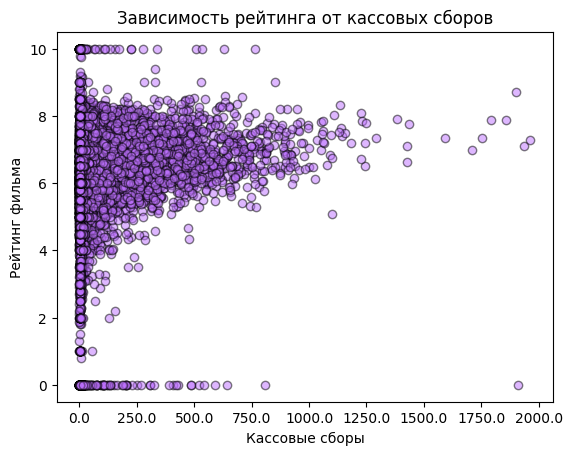

In [65]:
plt.scatter(
    df_filtered[df_filtered['current_revenue'] < 2000000000]['current_revenue'],
    df_filtered[df_filtered['current_revenue'] < 2000000000]['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Большинство фильмов имеют относительно низкие сборы, вне зависимости от рейтинга.
- Высокие сборы - чаще высокие рейтинги. На графике видно, что с увеличением значения кассовых сборов, фильмов становится меньше, однако рейтинг у них держится в районе 6-9.

**Линейный график - кол-во фильмов**

In [66]:
df_filtered['year'] = pd.to_datetime(df_filtered['release_date']).dt.year

In [67]:
films_year = df_filtered['year'].value_counts()
films_year = films_year.reset_index(drop=False)
films_year = films_year.sort_values(by='year')
films_year.head()

,year,count
108,1913,1
106,1914,2
111,1915,1
102,1916,3
105,1918,2


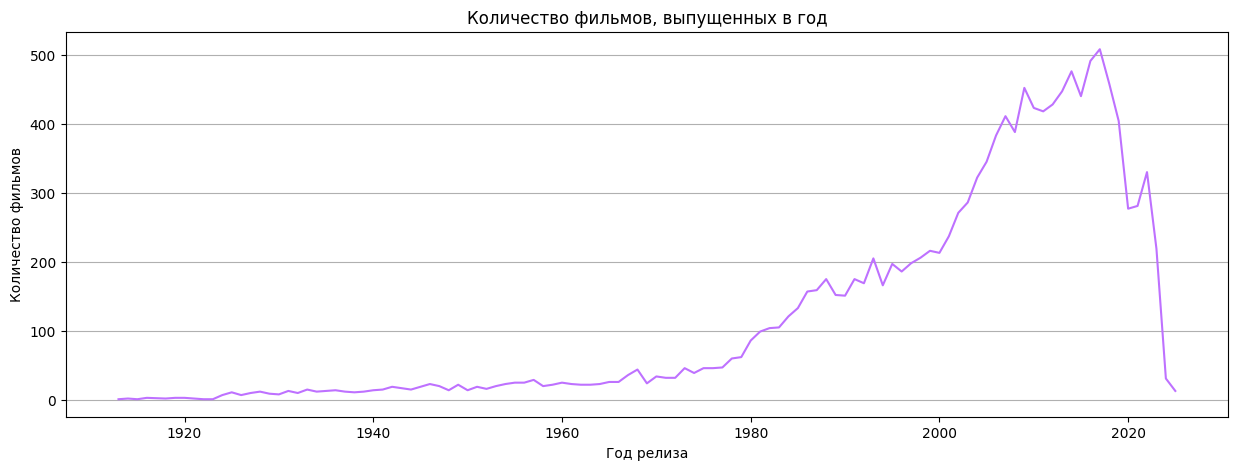

In [68]:
plt.figure(figsize=(15, 5))

plt.plot(films_year['year'],
         films_year['count'],
          color='#be71ff')

plt.title('Количество фильмов, выпущенных в год')
plt.xlabel('Год релиза')
plt.ylabel('Количество фильмов')
plt.grid(axis='y')
plt.show()

продолжение следует...